In [110]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# tune parameters
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [111]:
# acquire data
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
combine = [train_df, test_df]

In [112]:
# print features
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [113]:
# drop Cabin and Ticket feature
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [114]:
# extract name title from Name feature using regex
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [115]:
# replace rare titles with Rare
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [116]:
# convert catagorical title to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [117]:
# drop Name feature since we are done extracting title
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [118]:
# convert sex to gender and make it to numerical values
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


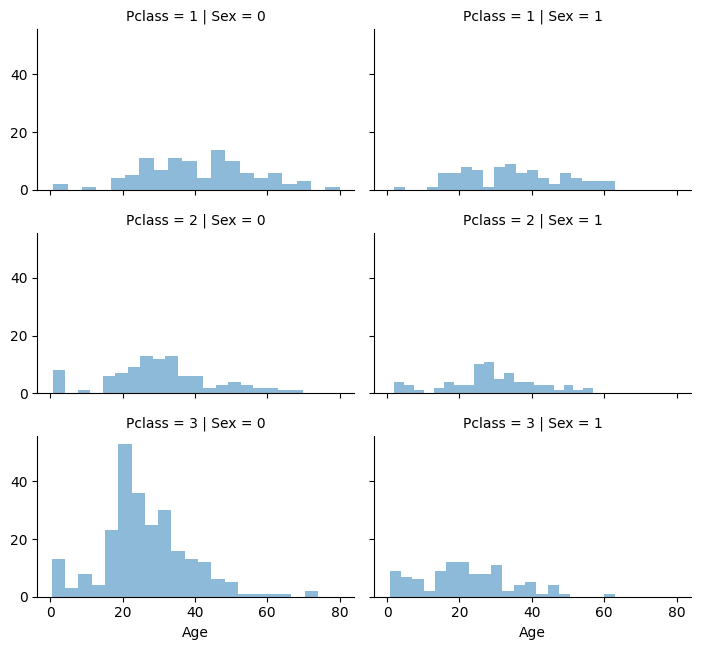

In [119]:
# use PClass and gender to find median for missing Age values
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [120]:
title_ages = np.zeros(5)

In [121]:
for dataset in combine:
    # get median of each title
    for i in range(5):
        guess_df = dataset[dataset['Title'] == i+1]['Age'].dropna()
        age_guess = guess_df.median()
        title_ages[i] = int( age_guess/0.5 + 0.5 ) * 0.5
        
    # fill age by title
    for i in range(5):
        dataset.loc[ (dataset['Title'] == i+1) & (dataset['Age'].isnull()), 'Age'] = title_ages[i]

In [122]:
age_bands = [
    [-1,18],
    [18,30],
    [30,40],
    [40,50],
    [50,64],
    [64,90]
]

In [123]:
# replace Age with ordinal values
for dataset in combine:
    for i in range(len(age_bands)):
        dataset.loc[ (dataset['Age'] > age_bands[i][0] ) & (dataset['Age'] <= age_bands[i][1] ), 'Age'] = i
        

train_df['Age'].value_counts()

Age
1.0    425
2.0    172
0.0    143
3.0     87
4.0     53
5.0     11
Name: count, dtype: int64

In [124]:
pd.crosstab(train_df['Title'], train_df['Age'])

Age,0.0,1.0,2.0,3.0,4.0,5.0
Title,,,,,,
1,35,296,97,50,29,10
2,61,93,21,6,4,0
3,7,33,50,23,13,0
4,40,0,0,0,0,0
5,0,3,4,8,7,1


In [125]:
# create new feature FamilySize so we can drop SibSp aad Parch 
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [126]:
# create another feature IsAlone
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [127]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [128]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [129]:
# embarked to numerical
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1.0,1,0,7.2500,0,1,2,0
1,1,1,1,2.0,1,0,71.2833,1,3,2,0
2,1,3,1,1.0,0,0,7.9250,0,2,1,1
3,1,1,1,2.0,1,0,53.1000,0,3,2,0
4,0,3,0,2.0,0,0,8.0500,0,1,1,1


In [130]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

C:\Users\jack9\AppData\Local\Temp\ipykernel_2004\31889810.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,892,3,0,2.0,0,0,7.8292,2,1,1,1
1,893,3,1,3.0,1,0,7.0000,0,3,2,0
2,894,2,0,4.0,0,0,9.6875,2,1,1,1
3,895,3,0,1.0,0,0,8.6625,0,1,1,1
4,896,3,1,1.0,1,1,12.2875,0,3,3,0


In [131]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False, observed=True).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [132]:
# convert to ordinal
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1.0,1,0,0,0,1,2,0
1,1,1,1,2.0,1,0,3,1,3,2,0
2,1,3,1,1.0,0,0,1,0,2,1,1
3,1,1,1,2.0,1,0,3,0,3,2,0
4,0,3,0,2.0,0,0,1,0,1,1,1
5,0,3,0,1.0,0,0,1,2,1,1,1
6,0,1,0,4.0,0,0,3,0,1,1,1
7,0,3,0,0.0,3,1,2,0,4,5,0
8,1,3,1,1.0,0,2,1,0,3,3,0
9,1,2,1,0.0,1,0,2,1,3,2,0


In [133]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

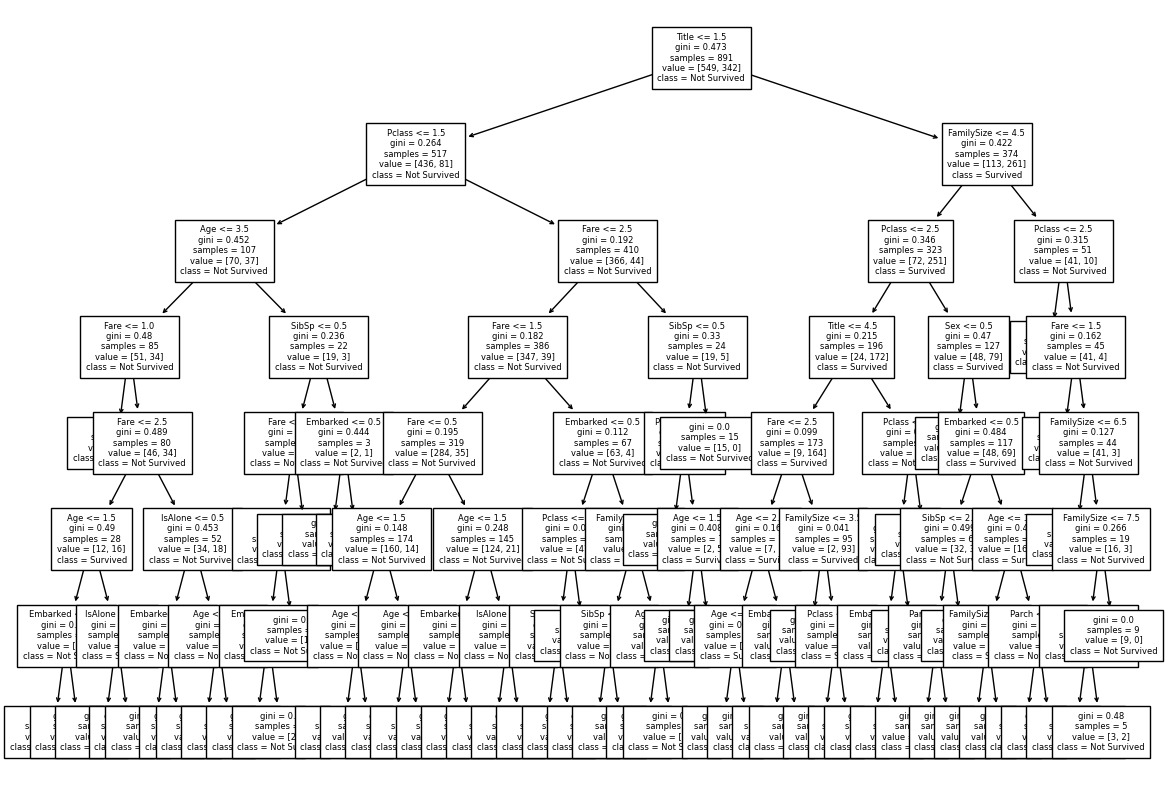

Tuned accuracy: 85.97%
With params: {'criterion': 'gini', 'max_depth': 7}


In [134]:
# Decision Tree

dt_params = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [None, 7, 10]
}

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=dt_params,cv=5,scoring='accuracy')
dt_grid_search.fit(X_train,Y_train)

best_tree_params = dt_grid_search.best_params_
best_tree = dt_grid_search.best_estimator_

# plot tree
plt.figure(figsize=(14,10))
plot_tree(best_tree,feature_names=list(X_train.columns),class_names=['Not Survived','Survived'],fontsize=6)
plt.show()

tuned_accuracy = round(best_tree.score(X_train, Y_train) * 100, 2)
print(f"Tuned accuracy: {tuned_accuracy}%\nWith params: {best_tree_params}")

In [135]:
# Random Forest

df_params ={
    "n_estimators":[ 10, 50, 100, 150, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth":[None, 7, 10]
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=df_params,cv=5,scoring='accuracy')
rf_grid_search.fit(X_train, Y_train)

best_forest_params = rf_grid_search.best_params_
best_forest = rf_grid_search.best_estimator_

forest_accuracy = round(best_forest.score(X_train, Y_train) * 100, 2)
print(f"Forest tuned accuracy: {forest_accuracy}%\nWith params: {best_forest_params}")


Forest tuned accuracy: 87.09%
With params: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}


In [136]:
# cross validation with shuffled data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

dt_accuracies = []
rf_accuracies = []

for train_indicies, test_indicies in kf.split(X_train):
    # get train and test data from splitted indices
    X_train_folded, X_test_folded = X_train.iloc[train_indicies], X_train.iloc[test_indicies]
    Y_train_folded, Y_test_folded = Y_train.iloc[train_indicies], Y_train.iloc[test_indicies]
    
    # fit model
    best_tree.fit(X_train_folded,Y_train_folded)
    best_forest.fit(X_train_folded,Y_train_folded)
    
    dt_accuracies.append(best_tree.score(X_test_folded,Y_test_folded))
    rf_accuracies.append(best_forest.score(X_test_folded,Y_test_folded))
    
dt_mean_accuracy = np.mean(dt_accuracies)
rf_mean_accuracy = np.mean(rf_accuracies)

pd.DataFrame({
    "Model":['Decision Tree', 'Random Forest'],
    "accuracy":np.array([dt_mean_accuracy,rf_mean_accuracy])*100
})

,Model,accuracy
0,Decision Tree,80.020087
1,Random Forest,82.717344


In [137]:
# do cross validation without shuffling
dt_cv_mean = cross_val_score(estimator=best_tree,X=X_train,y=Y_train,cv=5).mean()
rf_cv_mean = cross_val_score(estimator=best_forest,X=X_train,y=Y_train,cv=5).mean()

pd.DataFrame({
    "Model":['Decision Tree', 'Random Forest'],
    "accuracy":np.array([dt_cv_mean,rf_cv_mean])*100
})

,Model,accuracy
0,Decision Tree,79.800389
1,Random Forest,81.932082
